In [1]:
import ochre_gym

print("--- DIAGNOSTIC START ---")

# 1. Load the environment with vectorization OFF so we can read the names
env = ochre_gym.load(
    "bldg0112631-up11",
    override_equipment_controls={"HVAC Heating": ["Setpoint"]},
    vectorize_actions=True,
    vectorize_observations=False,
    
    # Episode settings
    start_time="2018-01-01 00:00:00",
    episode_duration="1 days",
    time_res="00:30",
    lookahead="12:00",            
    
    # DR Settings (Required to generate price data)
    dr_type="TOU",
    dr_subfolder="basic-v0",
    tou_price_file="time_of_use_price.csv"
)

# 2. Reset the environment to generate the first observation
obs, info = env.reset()

# 3. Print EVERY key available, sorted alphabetically
print("\n=== FULL OBSERVATION KEY LIST ===")
for i, key in enumerate(sorted(obs.keys())):
    print(f"{i+1:02d}: {key}")
print("=================================")

env.close()

Properties file weather station (G0800310) may be different from weather file used: C:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw


--- DIAGNOSTIC START ---


Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.



=== FULL OBSERVATION KEY LIST ===
01: Air Changes per Hour - Indoor (1/hour)
02: Air Density - Indoor (kg/m^3)
03: Day of month
04: Day of week
05: Energy Price ($)
06: Forced Ventilation Flow Rate - Indoor (m^3/s)
07: Forced Ventilation Heat Gain - Indoor (W)
08: Grid Voltage (-)
09: HVAC Heating Electric Power (kW)
10: HVAC Heating Reactive Power (kVAR)
11: Hour of day
12: Humidity Ratio - Indoor (-)
13: Infiltration Flow Rate - Attic (m^3/s)
14: Infiltration Flow Rate - Foundation (m^3/s)
15: Infiltration Flow Rate - Garage (m^3/s)
16: Infiltration Flow Rate - Indoor (m^3/s)
17: Infiltration Heat Gain - Attic (W)
18: Infiltration Heat Gain - Foundation (W)
19: Infiltration Heat Gain - Garage (W)
20: Infiltration Heat Gain - Indoor (W)
21: Internal Heat Gain - Indoor (W)
22: Lighting Electric Power (kW)
23: Lighting Reactive Power (kVAR)
24: Natural Ventilation Flow Rate - Indoor (m^3/s)
25: Natural Ventilation Heat Gain - Indoor (W)
26: Net Latent Heat Gain - Indoor (W)
27: Net Sen

In [2]:
import gymnasium as gym
import numpy as np
import ochre_gym

# -------------------------------------------------------------
# Environment configuration
# -------------------------------------------------------------

ENV_NAME = "bldg0112631-up11"

# Observation keys selected from the OCHRE environment
OBS_KEYS = [
    "Temperature - Indoor (C)",
    "Temperature - Outdoor (C)",
    "Energy Price ($)",
    "Hour of day"
]

def make_env(start_time: str, episode_duration: str):
    """
    Helper to create an OCHRE environment for a given start time and duration.
    The environment exposes a continuous heating setpoint action for SAC.
    """
    base_env = ochre_gym.load(
        ENV_NAME,
        override_equipment_controls={"HVAC Heating": ["Setpoint"]},
        vectorize_actions=True,
        vectorize_observations=True,
        override_ochre_observations_with_keys=OBS_KEYS,

        # Episode settings
        start_time=start_time,
        episode_duration=episode_duration,
        time_res="00:30",
        lookahead="12:00",

        # Demand response configuration
        dr_type="TOU",
        dr_subfolder="basic-v0",
        tou_price_file="time_of_use_price.csv",

        # Comfort constraints and reward scaling
        thermal_comfort_band_low=20,
        thermal_comfort_band_high=23,
        thermal_comfort_unit_penalty=50.0,
        reward_scale=0.1,

        # Logging options
        log_to_file=False,
        log_to_console=False,
    )
    return base_env


Properties file weather station (G0800310) may be different from weather file used: C:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


Using cpu device
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.49e+03  |
|    ep_rew_mean     | -4.62e+03 |
| time/              |           |
|    episodes        | 30        |
|    fps             | 26        |
|    time_elapsed    | 1675      |
|    total_timesteps | 44640     |
| train/             |           |
|    actor_loss      | 371       |
|    critic_loss     | 454       |
|    ent_coef        | 1.25      |
|    ent_coef_loss   | -0.00609  |
|    learning_rate   | 0.0003    |
|    n_updates       | 44539     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.49e+03  |
|    ep_rew_mean     | -2.63e+03 |
| time/              |           |
|    episodes        | 60        |
|    fps             | 25        |
|    time_elapsed    | 3451      |
|    total_timesteps | 89280     |
| train/             |           |
|    actor_loss      | 153       |
|  

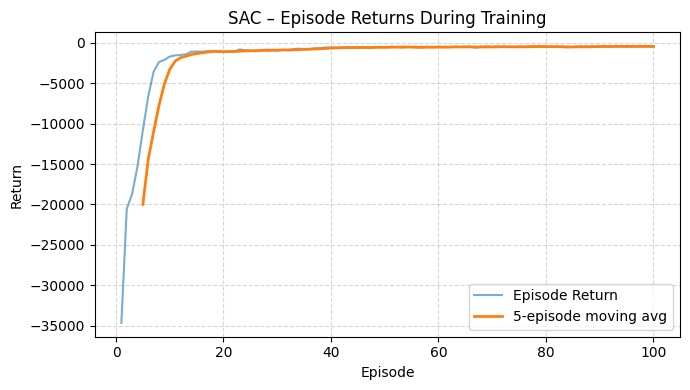

In [3]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# Monitor-wrapped training env (7-day episodes starting Jan 1)
# -------------------------------------------------------------
def make_train_env():
    return Monitor(make_env("2018-01-01 00:00:00", "31 days"))

train_env = DummyVecEnv([make_train_env])


# -------------------------------------------------------------
# Callback to record episode returns during training
# -------------------------------------------------------------
class EpisodeRewardCallback(BaseCallback):
    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        self.ep_returns: list[float] = []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        for info in infos:
            if "episode" in info:
                # total reward for that finished episode
                self.ep_returns.append(info["episode"]["r"])
        return True


# -------------------------------------------------------------
# SAC model definition
# -------------------------------------------------------------
sac_model = SAC(
    "MlpPolicy",
    train_env,
    verbose=2,
    learning_rate=3e-4,
    gamma=0.99,
    buffer_size=50_000,
    batch_size=256,
    tau=0.005,
    train_freq=1,
    gradient_steps=1,
    ent_coef="auto",
)

# -------------------------------------------------------------
# Train SAC and log episode returns
# -------------------------------------------------------------
callback = EpisodeRewardCallback()

sac_model.learn(
    total_timesteps=150_000,
    log_interval=30,
    callback=callback,
)

ep_returns_sac = np.asarray(callback.ep_returns, dtype=float)
print(f"Recorded {len(ep_returns_sac)} finished episodes.")


# -------------------------------------------------------------
# Plot: evolution of episode returns during training
# -------------------------------------------------------------
if len(ep_returns_sac) > 0:
    episodes = np.arange(1, len(ep_returns_sac) + 1)

    plt.figure(figsize=(7, 4))
    plt.plot(episodes, ep_returns_sac, label="Episode Return", alpha=0.6)

    # moving average
    window = 5
    if len(ep_returns_sac) >= window:
        ma = np.convolve(ep_returns_sac, np.ones(window) / window, mode="valid")
        plt.plot(
            np.arange(window, len(ep_returns_sac) + 1),
            ma,
            label=f"{window}-episode moving avg",
            linewidth=2,
        )

    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("SAC – Episode Returns During Training")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No episode returns were logged.")


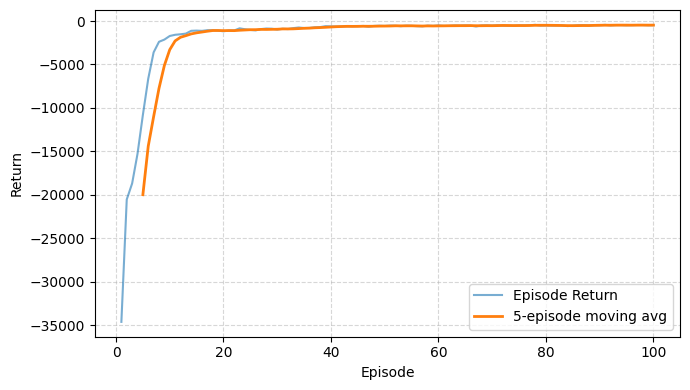

In [55]:
# -------------------------------------------------------------
# Plot: evolution of episode returns during training
# -------------------------------------------------------------
if len(ep_returns_sac) > 0:
    episodes = np.arange(1, len(ep_returns_sac) + 1)

    plt.figure(figsize=(7, 4))
    plt.plot(episodes, ep_returns_sac, label="Episode Return", alpha=0.6)

    # moving average
    window = 5
    if len(ep_returns_sac) >= window:
        ma = np.convolve(ep_returns_sac, np.ones(window) / window, mode="valid")
        plt.plot(
            np.arange(window, len(ep_returns_sac) + 1),
            ma,
            label=f"{window}-episode moving avg",
            linewidth=2,
        )

    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No episode returns were logged.")


Properties file weather station (G0800310) may be different from weather file used: C:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


Running RL Agent...
Running Baseline...


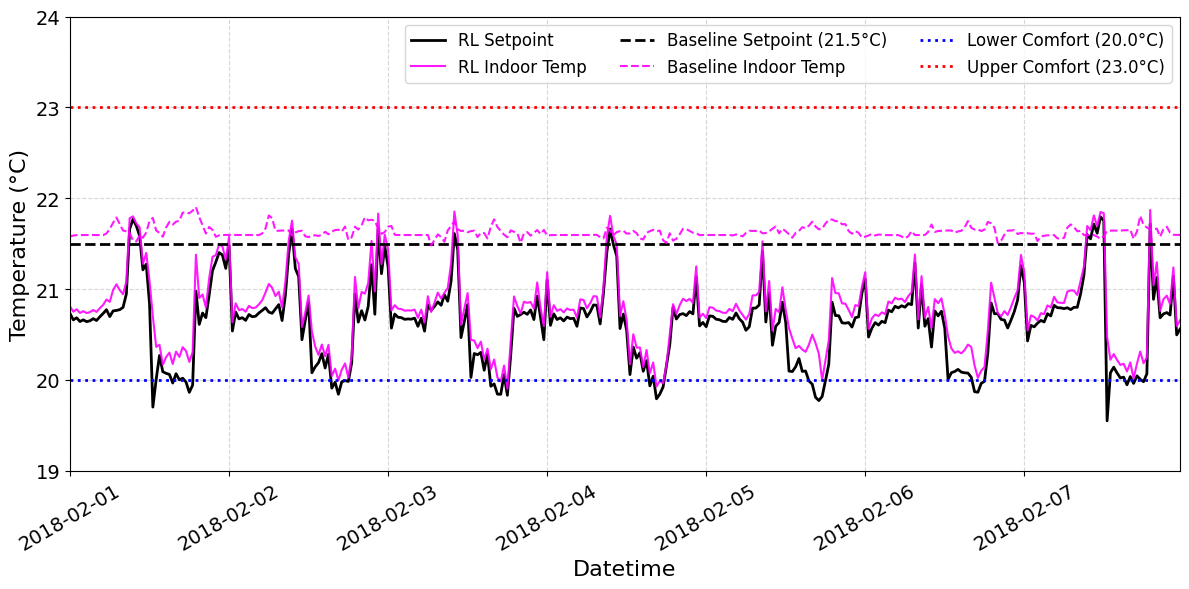

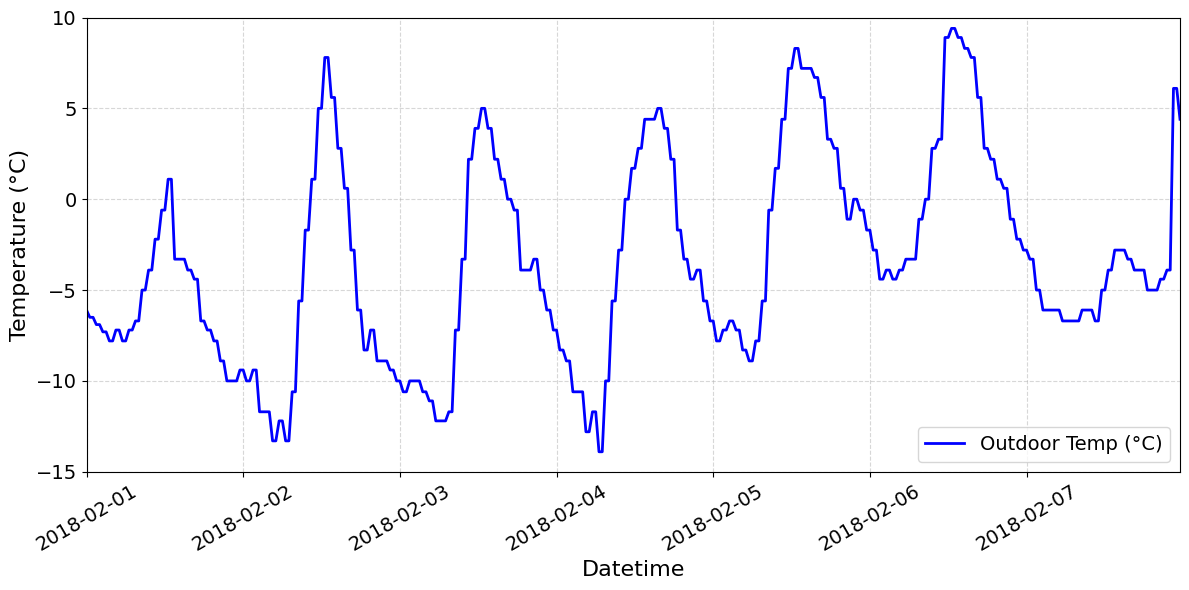

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===========================
# Helpers
# ===========================
def safe_datetime(info, t, start="2018-02-01", minutes=30):
    dt = info.get("Datetime", None) if isinstance(info, dict) else None
    if dt is None:
        return pd.Timestamp(start) + pd.Timedelta(minutes=minutes * t)
    if isinstance(dt, str):
        dt = pd.to_datetime(dt)
    return dt

def extract_indoor_temp(obs, info):
    if isinstance(info, dict) and ("Temperature - Indoor (C)" in info):
        return float(info["Temperature - Indoor (C)"])
    obs = np.asarray(obs).ravel()
    return float(obs[0]) if obs.size >= 1 else np.nan

def extract_outdoor_temp(obs, info):
    if isinstance(info, dict) and ("Temperature - Outdoor (C)" in info):
        return float(info["Temperature - Outdoor (C)"])
    obs = np.asarray(obs).ravel()
    return float(obs[1]) if obs.size >= 2 else np.nan

def extract_obs_components(obs):
    obs = np.asarray(obs).ravel()
    tin   = float(obs[0]) if obs.size >= 1 else np.nan
    tout  = float(obs[1]) if obs.size >= 2 else np.nan
    price = float(obs[2]) if obs.size >= 3 else np.nan
    hour  = float(obs[3]) if obs.size >= 4 else np.nan
    return tin, tout, price, hour

def get_comfort_band(default=(20.0, 23.0)):
    return default

# ===========================
# Baseline Controller
# ===========================
class RealisticThermostat:
    def __init__(self, setpoint=21.5):
        self.setpoint = np.array([setpoint], dtype=np.float32)

    def predict(self, obs, deterministic=True):
        return self.setpoint, None

# ===========================
# Evaluation Function
# ===========================
def evaluate_policy_with_actions(env, model, max_steps=2000):
    data = []
    obs, info = env.reset()

    for t in range(max_steps):
        action, _ = model.predict(obs, deterministic=True)
        action = np.asarray(action, dtype=np.float32).ravel()
        if action.size == 0:
            raise RuntimeError("Empty action from model.")
        sp = float(action[0])

        obs, r, terminated, truncated, info = env.step(action)
        tin, tout, price, hour = extract_obs_components(obs)

        data.append({
            "Datetime": safe_datetime(info, t),
            "Setpoint_RL": sp,
            "IndoorTemp_RL": extract_indoor_temp(obs, info),
            "OutdoorTemp_RL": extract_outdoor_temp(obs, info),
            "Tout": tout,
            "Price": price,
            "Hour": hour,
        })

        if terminated or truncated:
            break

    return pd.DataFrame(data)

# ===========================
# Run Simulations
# ===========================
# 1. Setup
env_feb = make_env("2018-02-01 00:00:00", "7 days")

# 2. RL Agent
print("Running RL Agent...")
env_feb.reset()
rl_df = evaluate_policy_with_actions(env_feb, sac_model)

# 3. Baseline
print("Running Baseline...")
env_feb.reset()
baseline_model = RealisticThermostat(setpoint=21.5)
base_df = evaluate_policy_with_actions(env_feb, baseline_model)

COMFORT_LOW, COMFORT_HIGH = get_comfort_band()

# ===========================
# Figure 1: Indoor Temperature Comparison
# ===========================
plt.figure(figsize=(12, 6))

# RL Plots (Solid)
plt.plot(rl_df["Datetime"], rl_df["Setpoint_RL"], color="black", linestyle="-", linewidth=2, label="RL Setpoint")
plt.plot(rl_df["Datetime"], rl_df["IndoorTemp_RL"], color="magenta", linestyle="-", alpha=0.9, linewidth=1.5, label="RL Indoor Temp")

# Baseline Plots (Dashed)
plt.plot(base_df["Datetime"], base_df["Setpoint_RL"], color="black", linestyle="--", linewidth=2, label="Baseline Setpoint (21.5°C)")
plt.plot(base_df["Datetime"], base_df["IndoorTemp_RL"], color="magenta", linestyle="--", alpha=0.9, linewidth=1.5, label="Baseline Indoor Temp")

# Comfort Bands
plt.hlines(COMFORT_LOW, rl_df["Datetime"].iloc[0], rl_df["Datetime"].iloc[-1], colors="blue", linestyles=":", linewidth=2, label=f"Lower Comfort ({COMFORT_LOW}°C)")
plt.hlines(COMFORT_HIGH, rl_df["Datetime"].iloc[0], rl_df["Datetime"].iloc[-1], colors="red", linestyles=":", linewidth=2, label=f"Upper Comfort ({COMFORT_HIGH}°C)")

plt.xlabel("Datetime", fontsize=16)
plt.ylabel("Temperature (°C)", fontsize=16)

# Axis Limits & Tick Sizes
plt.ylim(19, 24)
plt.yticks(np.arange(19, 25, 1), fontsize=14)
plt.xlim(rl_df["Datetime"].min(), rl_df["Datetime"].max())

# Legend
plt.legend(loc='upper right', ncol=3, fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

# X-Ticks Rotation & Size
plt.xticks(rotation=30, fontsize=14)

plt.tight_layout()
plt.show()

# ===========================
# Figure 2: Outdoor Temperature
# ===========================
plt.figure(figsize=(12, 6))
plt.plot(rl_df["Datetime"], rl_df["OutdoorTemp_RL"], color="blue", linewidth=2, label="Outdoor Temp (°C)")

plt.xlabel("Datetime", fontsize=16)
plt.ylabel("Temperature (°C)", fontsize=16)

# Axis Limits
plt.xlim(rl_df["Datetime"].min(), rl_df["Datetime"].max())
plt.ylim(-15, 10)
plt.yticks(np.arange(-15, 11, 5))

plt.grid(True, linestyle="--", alpha=0.5)

plt.xticks(rotation=30, fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. ROBUST EVALUATION FUNCTION
# ==========================================
def evaluate_policy_with_actions(env, model, max_steps=2000):
    """
    Run the policy and log setpoints, temps, AND POWER.
    Uses dictionary lookups based on your provided key list.
    """
    data = []
    obs, info = env.reset()

    for t in range(max_steps):
        # 1. Predict Action
        action, _ = model.predict(obs, deterministic=True)
        action = np.asarray(action, dtype=np.float32).ravel()
        
        if action.size == 0: 
             action = np.array([20.0], dtype=np.float32)
        
        sp = float(action[0])

        # 2. Step Environment
        step_result = env.step(action)
        if len(step_result) == 5:
            obs, r, terminated, truncated, info = step_result
        else:
            obs, r, terminated, info = step_result
            truncated = False

        # 3. DATA EXTRACTION
        
        # PRICE: Get directly from info
        # Fallback to alphabetical index 0 if missing in info
        obs_vec = np.asarray(obs).ravel()
        price = info.get("Energy Price ($)", float(obs_vec[0]))
        
        # TEMPS: Get from info (Items 45 & 46) or fallback to indices 2 & 3
        tin   = info.get("Temperature - Indoor (C)", float(obs_vec[2]))
        tout  = info.get("Temperature - Outdoor (C)", float(obs_vec[3]))
        
        # HOUR: Item 11
        hour  = info.get("Hour of day", float(obs_vec[1]))
        
        # POWER: Items 09 & 48
        # We prefer HVAC power, but fall back to Total if HVAC is missing/0
        hvac_power = info.get("HVAC Heating Electric Power (kW)", 0.0)
        if hvac_power == 0.0:
            hvac_power = info.get("Total Electric Power (kW)", 0.0)

        data.append({
            "Datetime": safe_datetime(info, t),
            "Setpoint_RL": sp,
            "IndoorTemp_RL": tin,
            "OutdoorTemp_RL": tout,
            "Price": price,
            "Hour": hour,
            "HVAC Power": hvac_power 
        })

        if terminated or truncated:
            break

    return pd.DataFrame(data)

# ==========================================
# 2. HELPER CLASSES & FUNCTIONS
# ==========================================
class RealisticThermostat:
    def __init__(self, setpoint=21.5):
        self.setpoint = np.array([setpoint], dtype=np.float32)
    def predict(self, obs, deterministic=True):
        return self.setpoint, None

def safe_datetime(info, t, start="2018-02-01", minutes=30):
    dt = info.get("Datetime", None) if isinstance(info, dict) else None
    if dt is None:
        return pd.Timestamp(start) + pd.Timedelta(minutes=minutes * t)
    if isinstance(dt, str):
        dt = pd.to_datetime(dt)
    return dt

def print_performance_report(df, name="Controller"):
    # 1. Calculate Energy Cost ($)
    # Formula: Power (kW) * Price ($/kWh) * Time (0.5 hours)
    power_col = "HVAC Power"
    
    # Debug: Check if we actually captured power
    avg_power = df[power_col].mean()
    if avg_power == 0:
        print(f"[{name}] WARNING: Average Power is 0.0 kW. Check extraction.")
    
    total_cost = (df[power_col] * df["Price"] * 0.5).sum()

    # 2. Calculate Thermal Discomfort (Degree-Hours)
    t_in = df["IndoorTemp_RL"]
    violation_low = (20.0 - t_in).clip(lower=0)
    violation_high = (t_in - 23.0).clip(lower=0)
    total_discomfort = (violation_low + violation_high).sum() * 0.5
    
    # 3. Print Results
    print(f"--- {name} Report ---")
    print(f"Total Energy Cost:   ${total_cost:.2f}")
    print(f"Avg Power Usage:     {avg_power:.2f} kW")
    print(f"Total Discomfort:    {total_discomfort:.2f} Degree-Hours")
    print(f"Avg Indoor Temp:     {t_in.mean():.2f} C")
    print(f"-----------------------")
    return total_cost, total_discomfort

# ==========================================
# 3. RUN THE COMPARISON
# ==========================================

# A. Run Baseline (21.5 C Fixed)
print("\n>>> Running Baseline (RealisticThermostat 21.5C)...")
baseline_model = RealisticThermostat(setpoint=21.5)
env_feb.reset() 
df_baseline = evaluate_policy_with_actions(env_feb, baseline_model)

# B. Run RL Agent (SAC)
print("\n>>> Running RL Agent (SAC)...")
env_feb.reset() 
df_rl = evaluate_policy_with_actions(env_feb, sac_model)

# C. Print Final Comparison
print("\n\n================ FINAL BENCHMARK RESULTS ================")
cost_base, disc_base = print_performance_report(df_baseline, "Baseline (RBC)")
cost_rl, disc_rl = print_performance_report(df_rl, "RL Agent (SAC)")

# Calculate Savings
cost_savings = cost_base - cost_rl
cost_savings_pct = (cost_savings / cost_base) * 100 if cost_base > 0 else 0.0

print(f"Money Saved by RL:   ${cost_savings:.2f} ({cost_savings_pct:.1f}%)")

if disc_rl < disc_base:
    print(f"Comfort Improved by: {disc_base - disc_rl:.2f} Degree-Hours")
else:
    print(f"Comfort Worsened by: {disc_rl - disc_base:.2f} Degree-Hours")


>>> Running Baseline (RealisticThermostat 21.5C)...

>>> Running RL Agent (SAC)...


================ FINAL BENCHMARK RESULTS ================
--- Baseline (RBC) Report ---
Total Energy Cost:   $844.01
Avg Power Usage:     2.34 kW
Total Discomfort:    0.00 Degree-Hours
Avg Indoor Temp:     21.63 C
-----------------------
--- RL Agent (SAC) Report ---
Total Energy Cost:   $696.23
Avg Power Usage:     2.21 kW
Total Discomfort:    0.12 Degree-Hours
Avg Indoor Temp:     20.77 C
-----------------------
Money Saved by RL:   $147.78 (17.5%)
Comfort Worsened by: 0.12 Degree-Hours


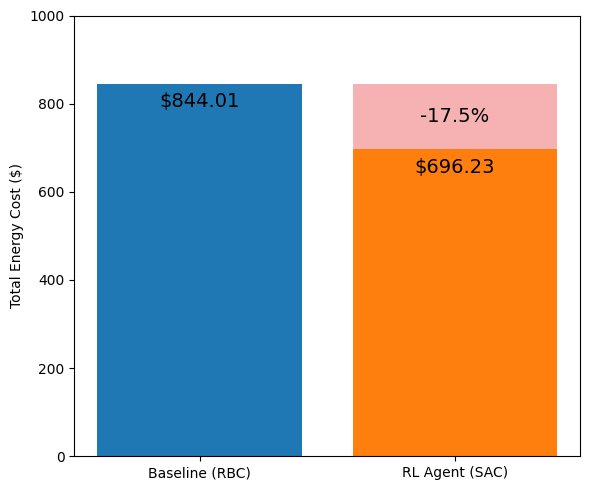

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Data
controllers = ['Baseline (RBC)', 'RL Agent (SAC)']
baseline_cost = 844.01
rl_cost = 696.23
savings = baseline_cost - rl_cost
savings_pct = (savings / baseline_cost) * 100

# Plotting
plt.figure(figsize=(6, 5))

# 1. Baseline Bar (Blue)
plt.bar(controllers[0], baseline_cost, color='tab:blue')

# 2. RL Agent Bar (Orange)
plt.bar(controllers[1], rl_cost, color='tab:orange')

# 3. Light Red Zone (Savings) stacked on RL Agent
plt.bar(controllers[1], savings, bottom=rl_cost, color='lightcoral', alpha=0.6)

plt.ylabel('Total Energy Cost ($)', color='black')
plt.ylim(0, 1000)
plt.yticks(np.arange(0, 1001, 200), color='black')
plt.xticks(color='black')

# Baseline Cost Label
plt.text(controllers[0], baseline_cost - 40, f'${baseline_cost:.2f}',
         ha='center', va='center', fontsize=14, color='black')

# RL Cost Label
plt.text(controllers[1], rl_cost - 40, f'${rl_cost:.2f}',
         ha='center', va='center', fontsize=14, color='black')

# Percentage Label
plt.text(controllers[1], rl_cost + (savings / 2), f'-{savings_pct:.1f}%',
         ha='center', va='center', fontsize=14, color='black')

plt.tight_layout()
plt.show()

Re-running RL evaluation with Index-based extraction...


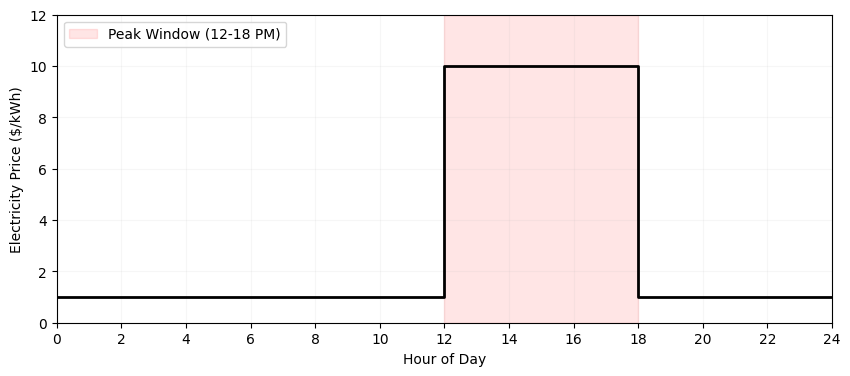

Peak Price:   $10.0000
Off-Peak:     $1.0000
Price Ratio:  10.0x


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. EVALUATION (Index-Based)
# ==========================================
def evaluate_policy_with_actions(env, model, max_steps=2000):
    data = []
    obs, info = env.reset()

    for t in range(max_steps):
        # 1. Predict
        action, _ = model.predict(obs, deterministic=True)
        action = np.asarray(action, dtype=np.float32).ravel()
        if action.size == 0: action = np.array([20.0], dtype=np.float32)
        sp = float(action[0])

        # 2. Step
        step_result = env.step(action)
        if len(step_result) == 5:
            obs, r, terminated, truncated, info = step_result
        else:
            obs, r, terminated, info = step_result
            truncated = False

        # 3. ROBUST DATA EXTRACTION (Using Alphabetical Indices)
        # Based on plots: 0=Price, 1=Hour, 2=Indoor, 3=Outdoor
        
        # Convert obs to flat array to be safe
        obs_vec = np.asarray(obs).ravel()
        
        price = float(obs_vec[0]) # Energy Price
        hour  = float(obs_vec[1]) # Hour
        tin   = float(obs_vec[2]) # Indoor Temp
        tout  = float(obs_vec[3]) # Outdoor Temp
        
        # Power must still come from info (it's not in the obs vector)
        hvac_power = info.get("HVAC Heating Electric Power (kW)", 
                              info.get("Total Electric Power (kW)", 0.0))

        data.append({
            "Datetime": safe_datetime(info, t),
            "Setpoint_RL": sp,
            "IndoorTemp_RL": tin,
            "OutdoorTemp_RL": tout,
            "Price": price,
            "Hour": hour,
            "HVAC Power": hvac_power
        })

        if terminated or truncated:
            break

    return pd.DataFrame(data)

# ==========================================
# 2. PRICE PROFILE
# ==========================================
print("Re-running RL evaluation with Index-based extraction...")
df_rl = evaluate_policy_with_actions(env_feb, sac_model)

one_day = df_rl.iloc[0:48].copy() # First 24 hours (0.0 to 23.5)

# FIX: Append a dummy row at Hour 24 so the step plot closes properly
last_price = one_day.iloc[-1]["Price"]
last_row = pd.DataFrame({"Hour": [24.0], "Price": [last_price]})
one_day = pd.concat([one_day, last_row], ignore_index=True)

# --- PLOT ---
plt.figure(figsize=(10, 4))
plt.step(one_day["Hour"], one_day["Price"], where='post', color='black', linewidth=2)
plt.xlabel("Hour of Day")
plt.ylabel("Electricity Price ($/kWh)")
plt.grid(True, alpha=0.1)
plt.xticks(range(0, 25, 2))

plt.xlim(0, 24)
plt.ylim(0, 12)

plt.axvspan(12, 18, color='red', alpha=0.1, label="Peak Window (12-18 PM)")
plt.legend()
plt.show()

# --- STATS ---
peak_mask = df_rl["Price"] > 5.0  
peak_price = df_rl[peak_mask]["Price"].mean()
off_peak_price = df_rl[~peak_mask]["Price"].mean()

print(f"Peak Price:   ${peak_price:.4f}")
print(f"Off-Peak:     ${off_peak_price:.4f}")
if off_peak_price > 0:
    print(f"Price Ratio:  {peak_price/off_peak_price:.1f}x")